In [1]:
import matplotlib
%matplotlib inline

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
import copy
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)

dtype = torch.FloatTensor

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{bm}']

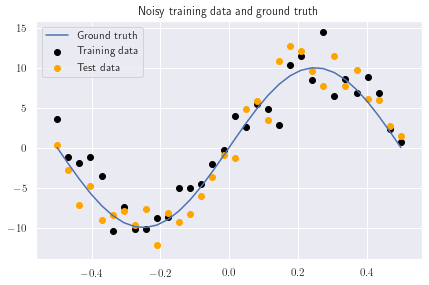

In [2]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 32
noise = 2.0

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)
y_test = f(X, sigma=noise)

fig = plt.figure(figsize=(6, 4))
plt.scatter(X, y, color='black', label='Training data')
plt.scatter(X, y_test, color='orange', label='Test data')

plt.plot(X, y_true, label='Ground truth')
plt.title('Noisy training data and ground truth')
plt.legend()
fig.tight_layout()

In [3]:
def gaussian_nll(mu, logvar, target, reduction: str = 'mean'):
    loss = torch.exp(-logvar) * torch.pow(target - mu, 2) + logvar
    return loss.mean() if reduction=='mean' else loss.sum()

In [4]:
def calc_uncert(preds, reduction='mean'):
    epi = np.std(preds[:,:,0], axis=0)
    ale = np.mean(preds[:,:,1], axis=0)
    uncert = ale + epi
    if reduction == 'mean':
        return ale.mean(), epi.mean(), uncert.mean()
    else:
        return ale, epi, uncert

In [5]:
class ModelDropout(nn.Module):
    def __init__(self, p=0.1):
        super(ModelDropout, self).__init__()
        self.p = p
        self.layer1 = nn.Linear(1, 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, 2)
    
    def forward(self, x):
        x = F.relu(F.dropout(self.layer1(x), p=self.p, training=True))
        x = F.relu(F.dropout(self.layer2(x), p=self.p, training=True))
        x = self.layer3(x)
        return x

In [6]:
LR = 0.01
weight_decay = 0.01

model_dropout = ModelDropout(p=0.01).type(dtype)
optim = torch.optim.Adam(model_dropout.parameters(), lr=LR, weight_decay=weight_decay)

x_torch = torch.from_numpy(X).type(dtype)
y_torch = torch.from_numpy(y).type(dtype)

pbar = tqdm(range(1000))
for i in pbar:
    optim.zero_grad()
    out = model_dropout(x_torch)
    loss = gaussian_nll(out[:,0], out[:,1], y_torch[:,0])
    
    loss.backward()
    optim.step()
    
    pbar.set_description('loss: %.6f' % loss.item())

loss: 2.294094: 100%|██████████| 1000/1000 [00:02<00:00, 443.61it/s]


100%|██████████| 100/100 [00:00<00:00, 3344.58it/s]


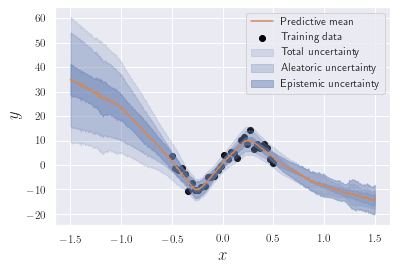

In [7]:
X_test = np.linspace(-1.5, 1.5, 500).reshape(-1, 1)
x_test_torch = torch.from_numpy(X_test).type(dtype)

y_pred_list = []

with torch.no_grad():
    for i in tqdm(range(100)):
        y_pred = model_dropout(x_test_torch)
        #y_pred[:,1] = torch.exp(y_pred[:,1])
        y_pred_list.append(y_pred.numpy())
    
y_preds = np.array(y_pred_list)

y_mean = np.mean(y_preds[:,:,0], axis=0)
ale, epi, uncert = calc_uncert(y_preds, reduction=None)

plt.plot(X_test, y_mean, color='#D1895C', label='Predictive mean');
plt.scatter(X, y, color='black', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * gaussian_filter1d(uncert, 5), 
                 y_mean - 2 * gaussian_filter1d(uncert, 5), 
                 color='#6C85B6',
                 alpha=0.2, label='Total uncertainty')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * gaussian_filter1d(ale, 5),
                 y_mean - 2 * gaussian_filter1d(ale, 5),
                 color='#6C85B6',
                 alpha=0.3, label='Aleatoric uncertainty')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * gaussian_filter1d(epi, 5), 
                 y_mean - 2 * gaussian_filter1d(epi, 5), 
                 color='#6C85B6',
                 alpha=0.5, label='Epistemic uncertainty')
#plt.title('Prediction')
plt.xlabel(r'$x$', fontsize=17)
plt.ylabel(r'$y$', fontsize=17)
plt.legend(loc='upper right');
plt.savefig('dropout_uncert.pdf', bbox_inches='tight')

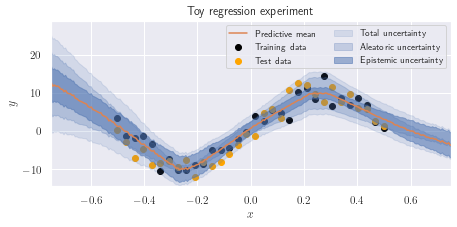

In [10]:
plt.figure(figsize=(6.4, 3.2))

plt.plot(X_test, y_mean, color=sns.color_palette()[1], label='Predictive mean');
plt.scatter(X, y, color='black', label='Training data')
plt.scatter(X, y_test, color='orange', label='Test data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 1.96 * gaussian_filter1d(uncert, 5), 
                 y_mean - 1.96 * gaussian_filter1d(uncert, 5), 
                 color=sns.color_palette()[0],
                 alpha=0.15, label='Total uncertainty')
plt.fill_between(X_test.ravel(), 
                 y_mean + 1.96 * gaussian_filter1d(ale, 5),
                 y_mean - 1.96 * gaussian_filter1d(ale, 5),
                 color=sns.color_palette()[0],
                 alpha=0.25, label='Aleatoric uncertainty')
plt.fill_between(X_test.ravel(), 
                 y_mean + 1.96 * gaussian_filter1d(epi, 5), 
                 y_mean - 1.96 * gaussian_filter1d(epi, 5), 
                 color=sns.color_palette()[0],
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Toy regression experiment')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(-0.75, 0.75)
plt.ylim(-14.5, 29)
plt.legend(loc='upper right', ncol=2, prop={'size': 9});
plt.tight_layout()
plt.savefig('dropout_uncert2.pdf', bbox_inches='tight')